<a href="https://colab.research.google.com/github/Piers14/sde_mc/blob/main/testing/sde_mc_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup:

In [2]:
!pip install git+'https://github.com/Piers14/sde_mc' --upgrade

  Cloning https://github.com/Piers14/sde_mc to /tmp/pip-req-build-9q1ufmrd
  Running command git clone -q https://github.com/Piers14/sde_mc /tmp/pip-req-build-9q1ufmrd
  Created wheel for sde-mc: filename=sde_mc-0.1-cp37-none-any.whl size=11063 sha256=c9b5c0fb6a98d9bfb7fafea932f1b5737ff7d1db74af838e0af31d3c5768e105
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3mh4oou/wheels/30/41/58/371909843d6e54dcabb04034994d939ba63496887aa2444d03
Successfully built sde-mc


In [3]:
from sde_mc import *
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Net vs Linear:

In [ ]:
# MC with no control variate
steps = 3000
trials = 1000
gbm = Gbm(mu=0.02, sigma=0.2, init_value=torch.tensor([1.0]), dim=1)
solver = SdeSolver(sde=gbm, time=3, num_steps=steps, device=device)

mc_stats = mc_simple(num_trials=trials, sde_solver=solver, payoff=BinaryAoN(strike=1.), discount=np.exp(-0.06))
mc_stats.print()

Mean: 0.64422  +/- 0.04183     Time taken (s): 0.48


In [ ]:
# MC with control variate
steps = 100
ts = torch.tensor([3*i / steps for i in range(1, steps+1)], device=device)
gbm = Gbm(mu=0.02, sigma=0.2, init_value=torch.tensor([1.0]), dim=1)
solver = SdeSolver(sde=gbm, time=3, num_steps=steps, device=device)

net_approx = NetApproximator(layer_sizes=[3], time_points=ts, discounter=ConstantShortRate(r=0.02), device=device, bs=128)
new_cv_stats = mc_control_variate(num_trials=(100, 1000), simple_solver=solver, approximator=net_approx,
                                  payoff=BinaryAoN(strike=1.), discounter=ConstantShortRate(r=0.02), step_factor=int(3000/steps))
new_cv_stats.print()

Time for final MC: 0.874687910079956
Mean: 0.63757  +/- 0.01888     Time taken (s): 1.45


## Variance as a loss function:

In [82]:
# MC with no control variate
steps = 200
trials = 100000
time_points = torch.tensor([3*i/steps for i in range(0, steps)], device=device)
Ys = ConstantShortRate(r=0.02)(time_points)

gbm = Gbm(mu=0.02, sigma=0.2, init_value=torch.tensor([1.0] * 2), dim=2)
solver = SdeSolver(sde=gbm, time=3, num_steps=steps, device=device)

mc_stats = mc_simple(num_trials=trials, sde_solver=solver, payoff=Rainbow(strike=1.), discount=np.exp(-0.06), return_normals=True)
mc_stats.print()

Mean: 0.28397  +/- 0.00200     Time taken (s): 0.14


In [83]:
paths, payoffs, normals = mc_stats.paths, mc_stats.payoffs, mc_stats.normals.squeeze(-1)

In [84]:
# Approximate Z using NN for F and the normals
# inputs to F depend on t, X(t)
# Z = F*N.sum()
# Compute G = f(X)Y + Z
# loss = variance(G)
# update parameters of NN

In [85]:
class NormalPathData(Dataset):
  def __init__(self, paths, payoffs, normals):
    self.paths = paths[:, :-1]
    self.payoffs = payoffs
    self.normals = normals
  
  def __len__(self):
    return len(self.payoffs)
    
  def __getitem__(self, idx):
    return (self.paths[idx], self.normals[idx]), self.payoffs[idx]

In [86]:
bs = 250
dim = gbm.dim
data = NormalPathData(paths, payoffs, normals)
dl = DataLoader(data, batch_size=bs, shuffle=True, drop_last=True)
F_approx = Mlp(dim+1, [30, 30], dim).to(device)
adam = optim.Adam(F_approx.parameters())

In [87]:
epochs = 10
rep_time_points = time_points.repeat(bs).unsqueeze(-1)
opt = adam
loss_arr = []
for epoch in range(epochs):
  F_approx.train()
  run_loss = 0
  for i, (xb, yb) in enumerate(dl):
    opt.zero_grad()
    inputs = torch.cat([rep_time_points, xb[0].reshape(dl.batch_size*steps, dim)], dim=-1)
    outputs = F_approx(inputs).view(dl.batch_size, steps, dim)
    Zs = (xb[1] * (outputs * Ys.view(1, len(Ys), 1))).sum(-1).sum(-1)
    var_loss = (yb + Zs).var()
    run_loss += var_loss.item()
    var_loss.backward()
    opt.step()
  loss_arr.append(run_loss / len(dl))
  print('{}: Train loss: {:.5f}     Train 95: {:.5f}'.format(epoch, loss_arr[epoch], np.sqrt(loss_arr[epoch])*2 / np.sqrt(trials)))
  F_approx.eval()


0: Train loss: 0.02358     Train 95: 0.00097
1: Train loss: 0.00173     Train 95: 0.00026
2: Train loss: 0.00121     Train 95: 0.00022
3: Train loss: 0.00109     Train 95: 0.00021
4: Train loss: 0.00099     Train 95: 0.00020
5: Train loss: 0.00097     Train 95: 0.00020
6: Train loss: 0.00088     Train 95: 0.00019
7: Train loss: 0.00088     Train 95: 0.00019
8: Train loss: 0.00086     Train 95: 0.00019
9: Train loss: 0.00082     Train 95: 0.00018


In [88]:
# Now increse number of steps - see if NN is still good approx of F
new_steps = 3000
new_trials = 100000
new_bs = 2000
assert not new_trials % new_bs
new_solver = SdeSolver(sde=gbm, time=3, num_steps=new_steps, device=device)
new_mc_stats = mc_simple(num_trials=new_trials, sde_solver=new_solver, payoff=Rainbow(strike=1.), discount=np.exp(-0.06), return_normals=True)
new_mc_stats.print()

Mean: 0.28450  +/- 0.00202     Time taken (s): 2.15


In [89]:
new_paths, new_payoffs, new_normals = new_mc_stats.paths, new_mc_stats.payoffs, new_mc_stats.normals.squeeze(-1)
new_data = NormalPathData(new_paths, new_payoffs, new_normals)
new_dl = DataLoader(new_data, batch_size=new_bs, shuffle=False)

In [90]:
new_time_points = torch.tensor([i*3/new_steps for i in range(0, new_steps)], device=device)
rep_new_time_points = new_time_points.repeat(new_dl.batch_size).unsqueeze(-1)
new_Ys = ConstantShortRate(r=0.02)(new_time_points)
run_sum = 0
run_sum_sq = 0
start = time.time()
with torch.no_grad():
  for (xb, yb) in new_dl:
    inputs = torch.cat([rep_new_time_points, xb[0].reshape(new_dl.batch_size*new_steps, dim)], dim=-1)
    outputs = F_approx(inputs).view(new_dl.batch_size, new_steps, dim)
    Zs = ((outputs * new_Ys.view(1, len(new_Ys), 1)) * xb[1]).sum(-1).sum(-1)
    gammas = yb + Zs
    run_sum += gammas.sum()
    run_sum_sq += (gammas * gammas).sum()
new_mn = (run_sum / new_trials).item()
new_sample_sd = np.sqrt(((run_sum_sq - (run_sum*run_sum) / new_trials) / (new_trials - 1)).item())
new_sd = new_sample_sd / np.sqrt(new_trials)
new_95 = new_sd * 2
end = time.time()
print(new_mn, new_95, end-start)

0.28526079654693604 0.00013487402384937714 7.881538391113281


In [81]:
Zs

torch.Size([2000])

In [ ]:
gamma = (new_payoffs + Zs.sum(1).squeeze(-1))
mn = gamma.mean().item()
sd = gamma.std().item()
print(mn, sd*2/np.sqrt(new_trials))

In [ ]:
Zs.sum(1).mean()

tensor(-0.0124, device='cuda:0', grad_fn=<MeanBackward0>)

## Comparison of derivative with linear regression:

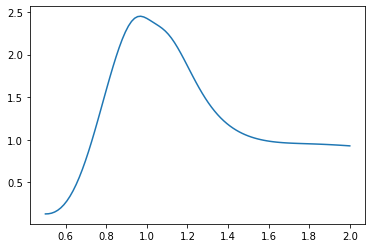

In [ ]:
t = torch.tensor(2., device=device)
xs = torch.linspace(0.5, 2., 100).to(device)
ins = torch.stack([t.repeat(len(xs)), xs], dim=-1)
with torch.no_grad():
  outs = F_approx(ins)
plt.plot(xs.cpu(), (outs.squeeze(1) / -(xs * 0.2)).cpu())

In [ ]:
lin_approx = LinearApproximator(basis=[basis_1, basis_2, basis_3], time_points=time_points, discounter=ConstantShortRate(r=0.02))
lin_approx.fit(paths, payoffs)

In [ ]:
lin_outs = lin_approx(400, t, xs)

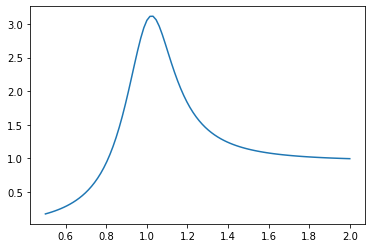

In [ ]:
plt.plot(xs.cpu(), lin_outs.cpu())